<a href="https://colab.research.google.com/github/egorgladin/gan-optimization/blob/develop/1d_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Networks 101

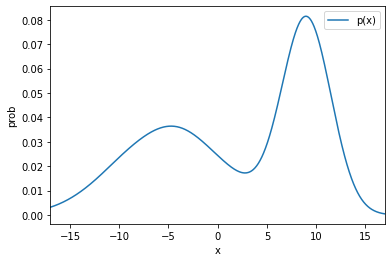

In [63]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.neighbors import KernelDensity

from IPython.display import display, clear_output
import time



SHIFT = 0

def sample_real_data(size):
    x1 = torch.randn(size, 1) * 1.5 + 9 + SHIFT
    x2 = torch.randn(size, 1) * 5.0 - 5 + SHIFT

    u = torch.rand(size, 1)
    
    return np.where(u > 0.5, x1, x2)


def plot_data(x, ax=plt):
    kde = KernelDensity(bandwidth=2.0, kernel='gaussian')
    kde.fit(x)

    x_grid = np.linspace(-17 + SHIFT, 17 + SHIFT, 1000)[:, None]
    logprob = kde.score_samples(x_grid)

    ax.set_xlim([-17 + SHIFT, 17 + SHIFT])
    ax.plot(x_grid, np.exp(logprob))
    
    return kde

def plot_classifier(cls, kde_real, kde_fake, ax=plt):
    x_grid = np.linspace(-17 + SHIFT, 17 + SHIFT, 1000)[:, None]

    p_pred = torch.sigmoid(cls(torch.from_numpy(x_grid).float().cuda())).cpu()
    
    p_real = np.exp(kde_real.score_samples(x_grid))
    p_fake = np.exp(kde_fake.score_samples(x_grid))
    
    p_bayes = p_real / (p_real + p_fake + 1e-7)
    
    ax.set_xlim([-17 + SHIFT, 17 + SHIFT])
    ax.plot(x_grid, p_pred.detach().cpu(), 'r--')
    ax.plot(x_grid, p_bayes, 'r')

X_real = sample_real_data(10000)

ax = plt.subplot()

plot_data(X_real, ax)

plt.legend(['p(x)'])
plt.xlabel('x')
plt.ylabel('prob')

plt.show()

In [0]:
import torch
from torch.optim.optimizer import Optimizer
from math import ceil

class GradSliding(Optimizer):
    """Lan's Gradient Sliding algorithm."""
    def __init__(self, params, L, M, D_tilde):
        defaults = dict(L=L, M=M, D_tilde=D_tilde)
        super().__init__(params, defaults)
        self.k = 0
        self.t = 0
        self.steps = 0
        self.mode = 'main'
    
    def upd_main_parameters(self):
        """
        Update parameters of main loop of gradient sliding.
        
        Increment k (counter in main loop). Change mode to PS
        (prox-sliding procedure). Calculate parameters according to the
        formulas in Lan's book:
        gamma, T, beta - formula (8.1.42); T - formula (8.1.42).
        gamma_next is value of gamma in the next iteration.
        """
        self.steps += 1
        self.k += 1
        self.mode = 'PS'

        self.gamma = 3 / (self.k + 2)
        self.gamma_next = 3 / (self.k + 3)
        
        L = self.defaults['L']
        M = self.defaults['M']
        D_tilde = self.defaults['D_tilde']
        T = ceil(M**2 * (self.k + 1)**3 / (D_tilde * L**2))
        self.T = int(T)
        
        self.P = 2 / ((self.T + 1) * (self.T + 2))
        self.beta = 9 * L * (1 - self.P) / (2 * (self.k + 1))
        # print(f">>> gamma={self.gamma:.2f}, T={self.T:.2f}, P={self.P:.2f}, beta={self.beta:.2f}")
    
    def upd_PS_parameters(self):
        """
        Update parameters of PS procedure.
        
        Increment t (counter in PS procedure). Calculate p and theta
        according to formula (8.1.39) in Lan's book. If this is the last
        PS iteration, change mode to main and reset counter.
        """
        self.steps += 1
        self.t += 1
        self.p = self.t / 2
        self.theta = 2 * (self.t + 1) / (self.t * (self.t + 3))
        # print(f"p={self.p:.2f}, theta={self.theta:.2f}")
        
        if self.t % self.T == 0:
            self.t = 0
            self.mode = 'main'

    @torch.no_grad()
    def to_eval(self):
        """Load x_bar as model parameters.
        
        Recommended to do only at the beginning of main loop."""
        for group in self.param_groups:
            for par in group['params']:
                if par.grad is None:
                    continue
                state = self.state[par]
                par.copy_(state['x_bar'])

    @torch.no_grad()
    def to_train(self):
        """Load x_underbar as model parameters.
        
        Recommended to do only at the beginning of main loop."""
        for group in self.param_groups:
            for par in group['params']:
                if par.grad is None:
                    continue
                state = self.state[par]
                par.copy_(state['x_underbar'])
        
    @torch.no_grad()
    def step(self, closure=None):
        """Perform Gradient Sliding step."""
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        # Part of main loop before PS (prox-sliding) procedure.
        # In this branch, par is x_underbar in notation of Lan's book.
        if self.mode == 'main':
            self.upd_main_parameters()
            for group in self.param_groups:
                for par in group['params']:
                    if par.grad is None:
                        continue
                    
                    state = self.state[par]
                    # State initialization.
                    if len(state) == 0:
                        state['x'] = par.clone()
                        state['x_bar'] = par.clone()
                        state['x_underbar'] = par.clone()
                    
                    state['df_x'] = par.grad
                    # At the beginning of PS procedure, gradient of h
                    # will be calculated at u0 = x.
                    par.copy_(state['x'])
                
        # PS procedure.
        # In this branch, par is u in notation of Lan's book.
        elif self.mode == 'PS':
            self.upd_PS_parameters()
            for group in self.param_groups:
                for par in group['params']:
                    if par.grad is None:
                        continue
                    
                    state = self.state[par]
                    if self.t == 1:
                        state['u_tilde'] = par.clone()
                    
                    dh_u = par.grad

                    # Formula (1) from our report.
                    numerator = self.beta * (state['x'] + self.p * par) \
                              - state['df_x'] - dh_u
                    par.copy_(numerator / (self.beta * (1 + self.p)))
                    
                    print(self.t)
                    state['u_tilde'] = (1 - self.theta) * state['u_tilde'] \
                                     + self.theta * par
                    
                    if self.t % self.T == 0:
                        # Finish PS procedure.
                        state['x'] = par
                        state['x_tilde'] = state['u_tilde']
                
                        # Part of main loop after PS procedure.
                        state['x_bar'] = (1 - self.gamma) * state['x_bar'] \
                                       + self.gamma * state['x_tilde']
                        # Beginning of main loop of new iteration.
                        # Now par is again x_underbar.
                        state['x_underbar'] = self.gamma_next * state['x'] \
                            + (1 - self.gamma_next) * state['x_bar']
                        par.copy_(state['x_underbar'])
                
        return loss

In [0]:
def calc_loss(real_preds=None, fake_preds=None, net_name=''):
    if net_name == 'dis':
        loss_real = -torch.log(real_preds)
        loss_fake = -torch.log(1 - fake_preds)

        loss = (loss_real + loss_fake) * 0.5
    
    elif net_name == 'gen':
        loss = -torch.log(fake_preds)

    return loss.mean()

def train_dis(dis, gen, dis_opt, gen_opt, batch_size, loss = calc_loss):
    # Forward real
    x_real = torch.from_numpy(sample_real_data(batch_size)).float().to(DEVICE)
    real_preds = dis(x_real)
    
    # Forward fake
    z = torch.randn(batch_size, 1).to(DEVICE)
    x_fake = gen(z)

    fake_preds = dis(x_fake.detach())

    # Discriminator lossesM
    loss_D = loss(real_preds, fake_preds, net_name='dis')

    # Discriminator step
    dis_opt.zero_grad()
    loss_D.backward()
    dis_opt.step()

    return loss_D.item()

def train_gen(dis, gen, dis_opt, gen_opt, batch_size, loss = calc_loss, ):
    # Forward fake
    z = torch.randn(batch_size, 1).cuda()
    x_fake = gen(z)

    fake_preds = dis(x_fake)

    # Generator losses
    loss_G = loss(None, fake_preds, net_name='gen')

    # Generator step
    gen_opt.zero_grad()
    loss_G.backward()
    gen_opt.step()

    return loss_G.item()

# Generator is an MLP that converts noise into output data

def make_lin_relu_gen():
    gen = nn.Sequential(
        nn.Linear(1, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
    )
    return gen

def make_lin_relu_dis():
    # Discriminator is mirroring the architecture of the generator
    dis = nn.Sequential(
        nn.Linear(1, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid()
    )
    return dis

def train_1d_gan(dis, gen, dis_opt, gen_opt, loss = calc_loss, n_iters=100, n_D_iters = 1, batch_size=128, eval_freq=10):
    # fig, axes = plt.subplots(ncols=3)
    for i in range(1, n_iters):    
        for _ in range(n_D_iters):
            loss_D = train_dis(dis, gen, dis_opt, gen_opt, batch_size = batch_size, loss = calc_loss)
        
        loss_G = train_gen(dis, gen, dis_opt, gen_opt, batch_size = batch_size, loss = calc_loss)
        
        losses_D_hist.append(loss_D)
        losses_G_hist.append(loss_G)
        

        if i % eval_freq == 0:
            # time.sleep(0.01)
            # display(f'n_iter: {i}, loss_D: {np.mean(losses_D_hist[-eval_freq:]):.3f}, loss_G: {np.mean(losses_G_hist[-eval_freq:]):.3f}')
            clear_output(True)

            

            fig, axes = plt.subplots(ncols=3, figsize=(25, 5))

            # print(f'Iter {i}')

            X_real = sample_real_data(10000)
            X_fake = gen(torch.randn(10000, 1).cuda()).detach().cpu().numpy()

            kde_real = plot_data(X_real, axes[0])
            kde_fake = plot_data(X_fake, axes[0])
            axes[0].legend(['p_real', 'q_fake'])
            # plt.show()

            plot_classifier(dis, kde_real, kde_fake, axes[1])
            axes[1].legend(['p_dis', 'p_bayes'])
            # plt.show()

            axes[2].plot(losses_D_hist)
            axes[2].plot(losses_G_hist)
            axes[2].set_ylim([0, 2.5])
            axes[2].legend(['loss_D', 'loss_G'])

            
            plt.show()

            display(f'n_iter: {i}, loss_D: {np.mean(losses_D_hist[-eval_freq:]):.3f}, loss_G: {np.mean(losses_G_hist[-eval_freq:]):.3f}')

In [0]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

gen = make_lin_relu_gen().to(DEVICE)
dis = make_lin_relu_dis().to(DEVICE)

gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-3, betas=(0.0, 0.999))
dis_opt = torch.optim.Adam(dis.parameters(), lr=1e-3, betas=(0.0, 0.999))


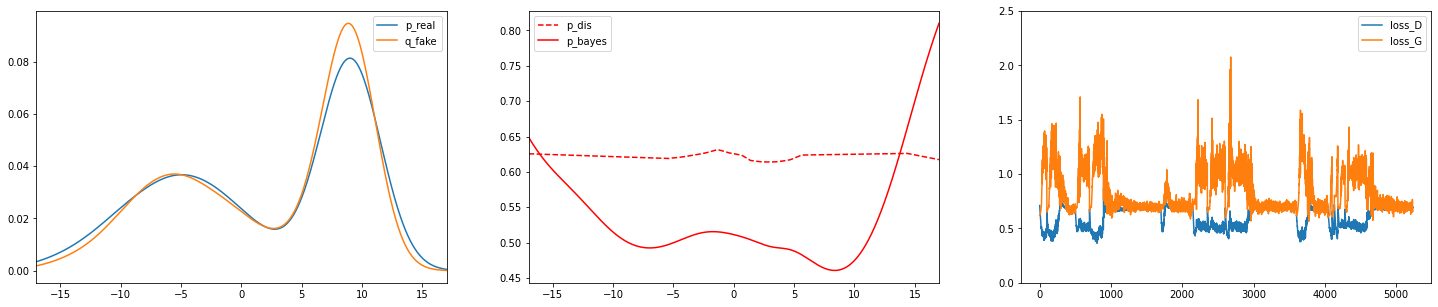

'n_iter: 950, loss_D: 0.694, loss_G: 0.698'

In [76]:
train_1d_gan(dis, gen, dis_opt, gen_opt, loss = calc_loss, n_iters=1001, n_D_iters = 1, batch_size=128, eval_freq=50)

In [0]:

gen = make_lin_relu_gen().to(DEVICE)
dis = make_lin_relu_dis().to(DEVICE)

gen_opt = torch.optim.Adam(gen.parameters(), lr=1e-3, betas=(0.0, 0.999))
dis_opt = GradSliding(dis.parameters(), L=0.1, M=0.1, D_tilde=300)


In [85]:
train_1d_gan(dis, gen, dis_opt, gen_opt, loss = calc_loss, n_iters=1000, n_D_iters = 1, batch_size=128)

0


KeyError: ignored